#Install Dependencies
<!-- apt install -y libsndfile-dev libpcap-dev -->
<!-- apt install python3-dev build-essential libpcap-dev -->
<!-- pip install --upgrade pip -->
<!-- pip install ddsp==3.6.0 -->
<!-- pip install tensorflow==2.11.0 -->
<!-- pip install numpy==1.23.5 protobuf==3.19.6 packaging==20.9 -->
<!-- pip install tensorflow-probability==0.19.0 -->
<!-- pip install --upgrade setuptools wheel packaging -->
<!-- pip install apache_beam -->
<!-- pip install packaging==20.9 protobuf==3.20.3 tensorflow-datasets==4.8.2 -->

In [1]:
!pip install gin ddsp librosa  
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import ddsp
import ddsp.training
from ddsp.training import metrics
import gin
import tensorflow.compat.v2 as tf

ModuleNotFoundError: No module named 'numpy'

In [13]:
# input_audio_path = r"C:\Users\prazw\Sarangi\test\test_flute.wav"
# output_audio_path = r"C:\Users\prazw\Sarangi\test\test2_output.wav"
# model_path = r"C:\Users\prazw\Sarangi\model"
input_audio_path="./input/input.wav"
output_audio_path="./output/output.wav"
model_path="./models/sarangi"
audio, sr = librosa.load(input_audio_path, sr=16000)
print(f"Audio shape: {audio.shape}")
print(f"Sample rate: {sr}")

Audio shape: (160000,)
Sample rate: 16000


In [18]:
#If the audio is mono (len(audio.shape) == 1), reshape it for processing
if len(audio.shape) == 1:
  audio = audio[np.newaxis, :]


# Setup the session.
ddsp.spectral_ops.reset_crepe()
# Compute features.
audio_features = metrics.compute_audio_features(audio)
# audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
audio_features['loudness_db'] = audio_features['loudness_db'].numpy().astype(np.float32)



#Load Model
gin_file = os.path.join(model_path, 'operative_config-0.gin')
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# ckpt = os.path.join(model_path, "\ckpt-3300.data-00000-of-00001")



# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)
time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size


gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]



# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(model_path)



# Build model by running a batch through it.
_ = model(audio_features, training=False)



from IPython.display import Audio
import numpy as np

# Assuming audio_gen is a NumPy array or tensor
audio_gen = model.get_audio_from_outputs(_)
# Convert to NumPy array if it's a TensorFlow tensor
if hasattr(audio_gen, 'numpy'):
    audio_gen = audio_gen.numpy()

# Normalize audio to prevent clipping (optional)
audio_gen = audio_gen / np.max(np.abs(audio_gen))

# Play audio in Jupyter Notebook
Audio(audio_gen, rate=16000)  # Replace 16000 with the correct sample rate

C:\Users\prazw\anaconda3\envs\tune\lib\site-packages\crepe\core.py:209: RuntimeWarning: invalid value encountered in divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]
C:\Users\prazw\anaconda3\envs\tune\lib\site-packages\librosa\core\convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


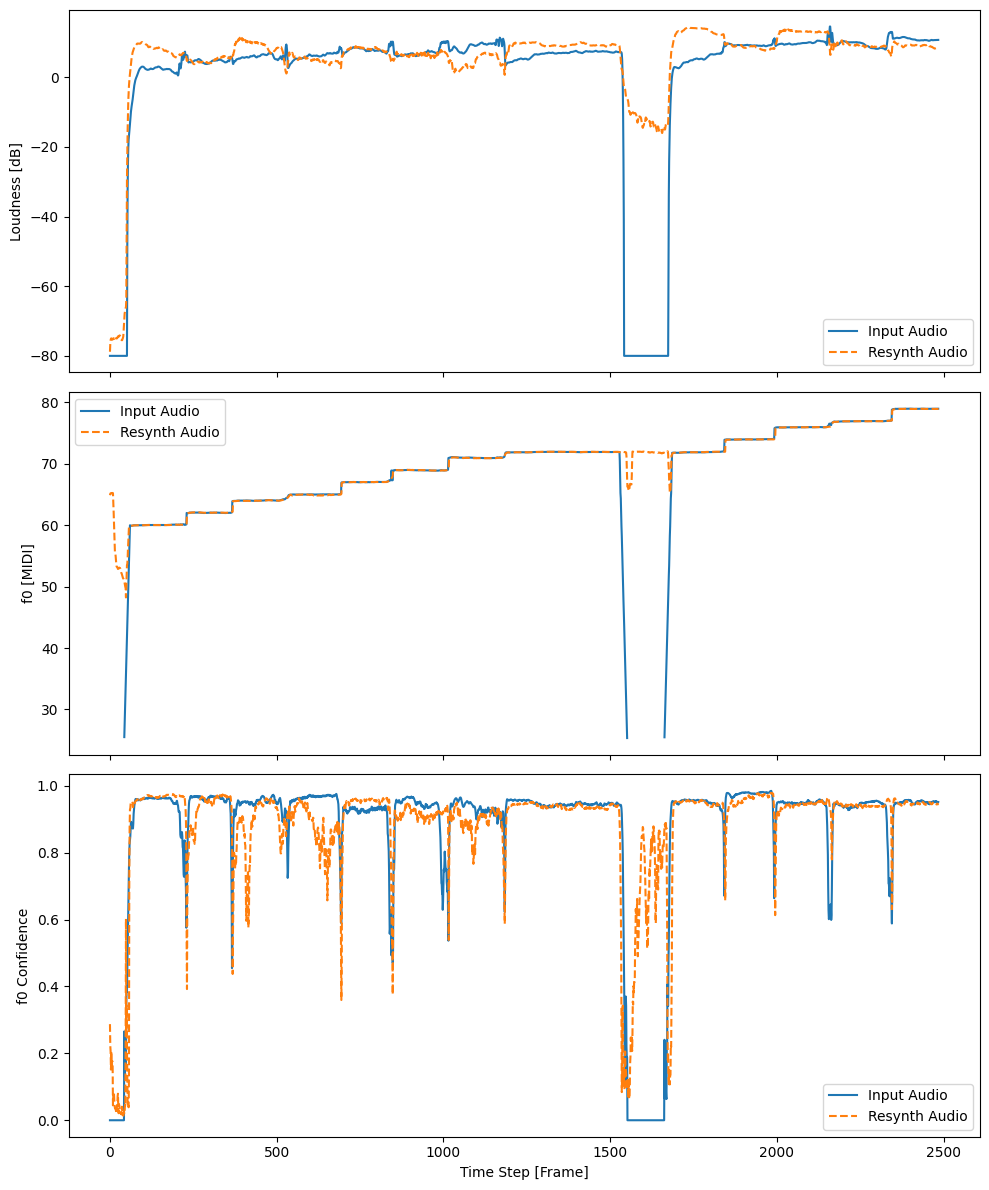

In [20]:
import matplotlib.pyplot as plt
import librosa
import numpy as np

# Define the trim value
TRIM = -15

# Process the input audio features
input_loudness_db = audio_features['loudness_db'][:TRIM]
input_f0_hz = librosa.hz_to_midi(audio_features['f0_hz'][:TRIM])
input_f0_confidence = audio_features['f0_confidence'][:TRIM]

# Process the resynthesized audio features
resynth_audio_features = metrics.compute_audio_features(audio_gen)
resynth_audio_features['loudness_db'] = resynth_audio_features['loudness_db'].numpy().astype(np.float32)

resynth_loudness_db = resynth_audio_features['loudness_db'][:TRIM]
resynth_f0_hz = librosa.hz_to_midi(resynth_audio_features['f0_hz'][:TRIM])
resynth_f0_confidence = resynth_audio_features['f0_confidence'][:TRIM]

# Plot features for both input and resynthesized audio
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(10, 12))

# Plot loudness
ax[0].plot(input_loudness_db, label="Input Audio")
ax[0].plot(resynth_loudness_db, label="Resynth Audio", linestyle='--')
ax[0].set_ylabel('Loudness [dB]')
ax[0].legend()

# Plot f0 in MIDI
ax[1].plot(input_f0_hz, label="Input Audio")
ax[1].plot(resynth_f0_hz, label="Resynth Audio", linestyle='--')
ax[1].set_ylabel('f0 [MIDI]')
ax[1].legend()

# Plot f0 confidence
ax[2].plot(input_f0_confidence, label="Input Audio")
ax[2].plot(resynth_f0_confidence, label="Resynth Audio", linestyle='--')
ax[2].set_ylabel('f0 Confidence')
ax[2].set_xlabel('Time Step [Frame]')
ax[2].legend()

plt.tight_layout()
plt.show()

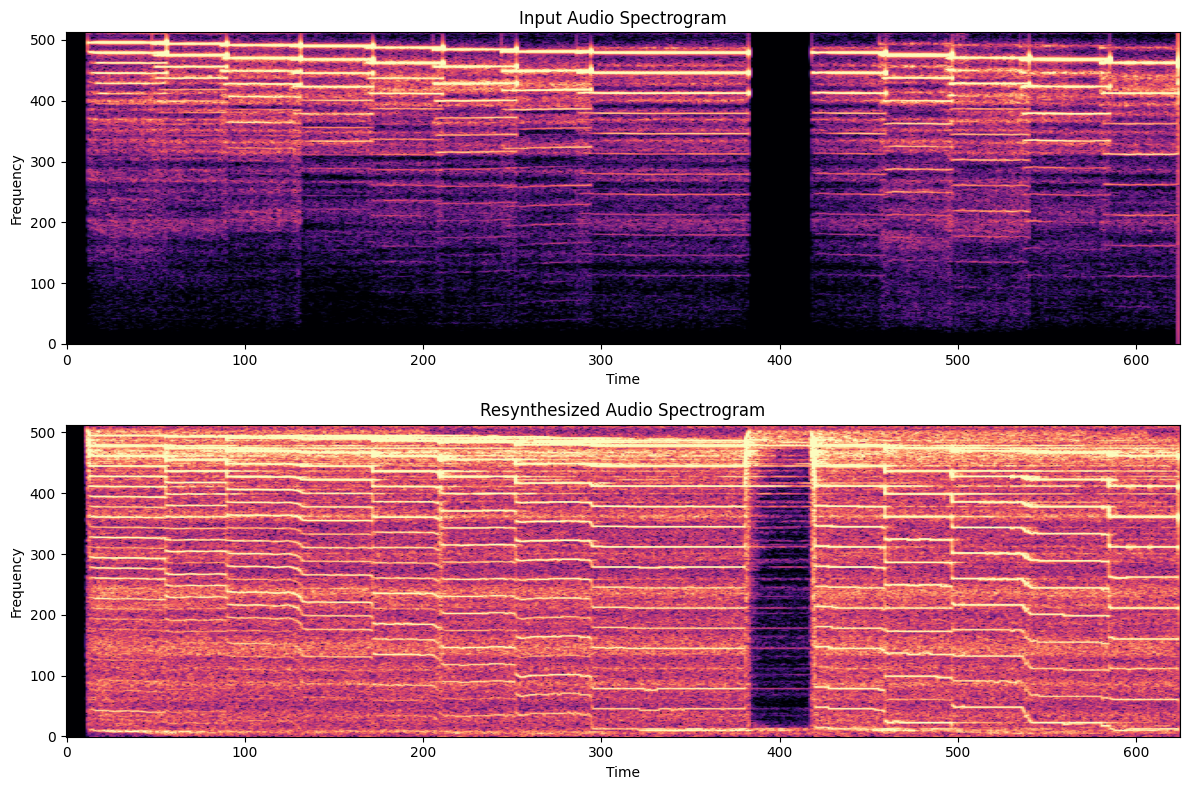

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import ddsp

# Compute log magnitude spectrogram
def compute_logmag_spectrogram(audio, size=768):
    """Compute log magnitude spectrogram of audio."""
    if len(audio.shape) == 2:  # If batched, take the first element
        audio = audio[0]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    return logmag.numpy() if hasattr(logmag, 'numpy') else logmag

# Compute spectrograms for input and resynthesized audio
input_spectrogram = compute_logmag_spectrogram(audio_features['audio'], size=1024)
resynth_spectrogram = compute_logmag_spectrogram(audio_gen, size=1024)

# Rotate spectrograms for better visualization
input_spectrogram = np.rot90(input_spectrogram)
resynth_spectrogram = np.rot90(resynth_spectrogram)

# Plot the spectrograms
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Input audio spectrogram
ax[0].imshow(input_spectrogram, aspect='auto', origin='lower', cmap='magma', vmin=-5, vmax=1)
ax[0].set_title("Input Audio Spectrogram")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Frequency")

# Resynthesized audio spectrogram
ax[1].imshow(resynth_spectrogram, aspect='auto', origin='lower', cmap='magma', vmin=-5, vmax=1)
ax[1].set_title("Resynthesized Audio Spectrogram")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()